**Made by: Lattari Amel**

# Introduction :

La sclérose latérale amyotrophique (SLA) est une maladie neurodégénérative affectant les neurones moteurs, conduisant à une paralysie progressive. Bien que les mécanismes exacts restent inconnus, l'expression génique différentielle pourrait jouer un rôle clé. Étant une passionnée du domaine médical, j'ai choisi d'explorer la SLA afin d'illustrer le processus ETL dans un contexte réel et significatif. Ce projet met en exergue l'utilisation de l'ETL pour préparer minutieusement les données RNA-Seq, qui sont ensuite analysées pour identifier des expressions géniques potentiellement liées à la SLA. En complément, des techniques de visualisation comme la PCA et les volcano plots enrichissent notre compréhension des données, facilitant la découverte de biomarqueurs candidats et offrant des perspectives plus claires sur les mécanismes de cette maladie complexe.

# Partie 1: ETL

In [1]:
import pandas as pd
import glob
import re
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
pd.options.mode.chained_assignment = None 
import unittest
from lxml import etree
import matplotlib.patches as mpatches
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Compter les fichiers RNA-Seq .txt
rna_seq_files = glob.glob('./Data/*.txt')
print(f"Nombre de fichiers RNA-Seq: {len(rna_seq_files)}")

# Vérifier la présence du fichier XML d'annotations
xml_files = glob.glob('./Data/*.xml')
print(f"Fichier XML d'annotations trouvé: {'Oui' if len(xml_files) > 0 else 'Non'}")


Nombre de fichiers RNA-Seq: 176
Fichier XML d'annotations trouvé: Oui


**Commentaires:**

On a 176 fichiers textes représentant des données RNA-Seq issues d'échantillons cérébraux, permettant l'analyse de l'expression génique dans le contexte de la SLA. Ces fichiers offrent une vue détaillée des niveaux d'expression de milliers de gènes. En parallèle, 1 fichier d'annotations contient des métadonnées cruciales sur ces échantillons, telles que l'identité des sujets, leur groupe (SLA ou témoin), et la source des échantillons. 

In [3]:
path = "./Data/GSE124439_family.xml"
class TestAnnotationFile(unittest.TestCase):
    
    def test_missing_values(self):
        # Teste si il y a des valeurs manquantes dans les éléments importants
        xml_tree = etree.parse(path)
        xml_root = xml_tree.getroot()
        for sample in xml_root.iter('Sample'):
            # Liste des éléments à vérifier pour les valeurs manquantes
            elements_to_check = ['Title', 'Organism', 'Channel', 'Characteristic[@tag="disease status"]']
            for elem_name in elements_to_check:
                element = sample.find(elem_name)
                # Vérifie si l'élément est absent ou si sa valeur est vide
                if element is None or element.text is None or element.text.strip() == '':
                    self.fail(f"L'élément {elem_name} est manquant ou vide dans l'échantillon {sample.attrib['iid']}")

    
    def test_xml_file_format(self):
        # Teste si le fichier XML a le bon format
        try:
            etree.parse(path)
        except etree.XMLSyntaxError:
            self.fail("The XML file is not well-formed")
    def test_homosapiens_species(self):
        # Teste si tous les échantillons proviennent d'Homo sapiens c'est à dire si se sont tous des échantillons d'humains
        annotation_file = path
        xml_tree = etree.parse(annotation_file)
        xml_root = xml_tree.getroot()
        for sample in xml_root.iter('Sample'):
            organism_elem = sample.find('Organism')
            if organism_elem is None or organism_elem.attrib['taxid'] != '9606':
                self.fail(f"Sample {sample.attrib['iid']} is not from Homo sapiens")

    def test_unique_subject_id(self):
        # Teste si chaque échantillon a un unique subject ID 
        xml_tree = etree.parse(path)
        xml_root = xml_tree.getroot()
        subject_ids = set()
        for sample in xml_root.iter('Sample'):
            subject_id = sample.find('Title').text
            if subject_id in subject_ids:
                self.fail(f"Sample {sample.attrib['iid']} has a duplicate subject ID")
            subject_ids.add(subject_id)

    def test_sample_group(self):
        # Teste si tous les échantillons d'un meme groupe appartiennent ont le meme status pour la maladie
        xml_tree = etree.parse(path)
        xml_root = xml_tree.getroot()
        sample_groups = {}
        for sample in xml_root.iter('Sample'):
            sample_group = sample.find('Channel').text
            if sample_group not in sample_groups:
                sample_groups[sample_group] = set()
            sample_groups[sample_group].add(sample.attrib['iid'])

        for sample_group, samples in sample_groups.items():
            disease_status = None
            for sample in samples:
                sample_disease_status = sample.find('Characteristic[@tag="disease status"]')
                if sample_disease_status is not None and isinstance(sample_disease_status.text, str):
                    if disease_status is None:
                        disease_status = sample_disease_status.text
                    elif disease_status != sample_disease_status.text:
                        self.fail(f"All samples in group {sample_group} do not have the same disease status")
                else:
                    self.fail(f"Sample {sample.attrib['iid']} does not have a valid disease status")
                    

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.029s

OK


**Commentaires:**

Avant de commencer l'analyse des données, il est essentiel de vérifier et de valider la qualité
des fichiers d'annotation. Dans cette étape, nous avons utilisé des tests unitaires pour s'assurer
que les données sont conformes aux critères requis. Les tests ont été effectués à l'aide de la
bibliothèque unittest et ont été conçus pour valider plusieurs aspects des données d'annotation
contenues dans le fichier XML.

Tout d'abord, nous avons vérifié que le fichier XML est bien formé et respecte la syntaxe
XML. Le test test_xml_file_format s'assure que le fichier peut être analysé sans erreur. Dans
notre cas, le fichier XML est bien formé et a passé le test.
Ensuite, pour garantir l'intégrité des données avant l'analyse, on a  implémenté test_missing_values, pour identifier toute valeur manquante ou élément vide dans le fichier XML.

De plus, nous avons vérifié que tous les échantillons proviennent de la même espèce, Homo
sapiens. Le test test_homosapiens_species parcourt les éléments 'Sample' et vérifie que
l'attribut 'taxid' de l'élément 'Organism' est égal à '9606', qui correspond à Homo sapiens. Tous
les échantillons de notre étude sont bien issus de la même espèce.

De plus, nous avons vérifié que chaque échantillon possède un identifiant de sujet unique. Le
test test_unique_subject_id parcourt les éléments 'Sample' et s'assure qu'il n'y a pas de
doublons dans les identifiants de sujet. Dans notre étude, tous les échantillons ont des
identifiants de sujet uniques.

Enfin, nous avons vérifié que tous les échantillons d'un même groupe ont le même statut de
maladie. Le test test_sample_group regroupe les échantillons par groupe et compare leur
statut de maladie. Si des différences sont détectées, le test échoue. Dans notre cas, tous les
échantillons appartenant à un même groupe ont bien le même statut de maladie.
Ainsi, tous les tests ont réussi, garantissant la qualité et la cohérence des données d'annotation
pour notre étude. Cette validation nous permet de poursuivre l'analyse en toute confiance.


In [4]:
data_path = "./Data"
annotation_file = f"{data_path}/GSE124439_family.xml"

class CreateDataframe: 
    def __init__(self, filepath, xml_file_name):
        self.file_path = filepath
        self.df_raw = None
        self.df_full = None
        self.df_rem = None
        self.xml = xml_file_name
        
    def import_raw_data(self):
        pdList = []  # Liste pour stocker temporairement tous les dataframes (un pour chaque fichier txt)

        # Extraction des données brutes à partir de fichiers txt dans le répertoire spécifié
        for fname in glob.glob(f"{self.file_path}/*.txt"):
            df = pd.read_table(fname)  # Lecture du fichier txt dans un dataframe
            sample_name = re.search("GSM\d+", fname).group()  # Extraction du nom de l'échantillon du nom de fichier
            df.rename(index=df["gene/TE"], inplace=True)  # Transformation : Renommer l'index (lignes) en utilisant la colonne contenant le nom du gène
            df.drop(columns=df.columns[0], axis=1, inplace=True)  # Transformation : Supprimer la première colonne contenant le nom du gène
            df.rename(columns={df.columns[0]: sample_name}, inplace=True)  # Transformation : Renommer la colonne avec le nom de l'échantillon
            pdList.append(df)  # Chargement : Ajouter le dataframe actuel à la liste

        data_matrix = pd.concat(pdList, axis=1)  # Transformation : Concaténer tous les dataframes en un seul
        data_matrix = data_matrix.transpose()  # Transformation : Transposer le dataframe

        self.df_raw = data_matrix  # Chargement : Stocker le dataframe résultant dans l'attribut de la classe
        return self.df_raw

    def import_full_df(self, df_raw):
        # Extraction des métadonnées à partir du fichier XML
        with open(f'{self.file_path}/{self.xml}', 'r') as f:
            data = f.read()
        Bs_data = BeautifulSoup(data, "xml")
        samples = Bs_data.find_all("Sample")

        # Transformation et chargement des métadonnées dans le dataframe
        df_raw['Sample group'] = 1
        df_raw["Subject id"] = 1

        for sample in samples:
            iid = sample.get('iid')
            df_raw.loc[iid, "Subject id"] = sample.find(tag="subject id").string.strip()
            df_raw.loc[iid, 'Sample group'] = sample.find(tag="sample group").string.strip()
            region = sample.find(tag="cns subregion").string.strip()
            
            # Transformation : Regrouper Motor Cortex (Medial) et Motor Cortex (Lateral) avec Motor Cortex
            if region == "Motor Cortex (Medial)" or region == "Motor Cortex (Lateral)":
                region = "Motor Cortex"
            df_raw.loc[iid, "Source"] = region
        
        self.df_full = df_raw  # Chargement : Stocker le dataframe résultant dans l'attribut de la classe
        return self.df_full

    def get_df_raw(self):
        if self.df_raw is None:
            self.import_raw_data()
        return self.df_raw
    
    def get_df_full(self, df_raw):
        if self.df_full is None:
            self.import_full_df(df_raw)
        return self.df_full
    
    def df_without_other(self, df_full):
        # Transformation : Filtrer le dataframe pour exclure les échantillons de "Other Neurological Disorders"
        self.df_rem = df_full[df_full["Sample group"] != "Other Neurological Disorders"]
        return self.df_rem

# Création de l'instance de la classe CreateDataframe
create_df = CreateDataframe(data_path, "GSE124439_family.xml")

# Extraction des données brutes
df_raw = create_df.get_df_raw()  

# Transformation et chargement des métadonnées
df_full = create_df.get_df_full(df_raw) 

# Filtrage pour exclure les échantillons de "Other Neurological Disorders"
df_rem = create_df.df_without_other(df_full)


**Extraction:** 
- Les données sont extraites des 176 fichiers texte, chaque fichier représentant un échantillon avec des informations sur l'expression génique. Parallèlement, un fichier XML contenant les annotations des échantillons est également extrait.

**Transformation:**
- Renommage d'Index: Les index des dataframes individuels, issus de chaque fichier texte, sont renommés pour correspondre aux noms des gènes, facilitant l'identification et les analyses ultérieures.
- Suppression de Colonnes: Les colonnes redondantes ou non nécessaires sont supprimées pour ne garder que les données d'expression génique pertinentes.
- Intégration des Métadonnées: Les informations extraites du fichier XML, telles que l'identité du sujet et le groupe d'échantillons, sont ajoutées au dataframe. Cette étape enrichit le dataset avec des données contextuelles essentielles pour l'analyse.
- Regroupement des Régions Cérébrales: Certains échantillons provenant de régions cérébrales spécifiques sont regroupés pour simplifier l'analyse.

**Chargement:**
- Concaténation et Transposition: Les différents dataframes sont fusionnés en un seul grand tableau, puis transposés pour aligner les échantillons en lignes et les gènes en colonnes, créant ainsi un format adapté à l'analyse statistique.
- Filtrage des Échantillons: Les échantillons non pertinents pour l'étude, tels que ceux classés dans des groupes de maladies neurologiques autres que la SLA, sont exclus du dataset final.

In [5]:
# Enregistrement du dataframe df_rem au format CSV
df_rem.to_csv('./dataset_final.csv', index=False)

In [6]:
df_final = pd.read_csv('dataset_final.csv')
df_final

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA,Sample group,Subject id,Source
0,76,193,0,4278,140,102,2,3,141,0,...,929,67,456,104,427,1619,1751,ALS Spectrum MND,NEUPU334DL1,Frontal Cortex
1,124,332,0,3516,141,173,3,2,192,0,...,936,110,479,120,503,1646,1839,ALS Spectrum MND,NEUUF289NRL,Frontal Cortex
2,64,290,0,4752,118,174,8,2,135,0,...,726,61,358,107,347,1284,1469,ALS Spectrum MND,NEUKN209FNW,Frontal Cortex
3,134,300,0,6077,171,42,8,5,225,0,...,966,119,460,109,399,1619,1724,ALS Spectrum MND,NEUXR145UBL,Frontal Cortex
4,23,113,0,2130,72,71,2,3,21,0,...,658,72,320,73,311,1102,1169,ALS Spectrum MND,NEUMY028JH4,Frontal Cortex
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,27,98,0,2218,92,51,0,3,82,1,...,821,104,493,121,461,1620,2003,ALS Spectrum MND,NEUWX086DGZ,Frontal Cortex
158,15,39,0,957,74,48,1,2,21,0,...,635,63,267,65,256,866,977,ALS Spectrum MND,NEUKM699KKH,Frontal Cortex
159,22,102,0,1706,83,178,1,3,31,0,...,1152,96,582,124,539,1742,1939,ALS Spectrum MND,NEUEC006FND,Frontal Cortex
160,22,101,0,2131,142,143,5,1,36,0,...,1198,97,562,132,540,2032,2135,ALS Spectrum MND,NEUME287RK2,Frontal Cortex


# Partie 2: Visualisations

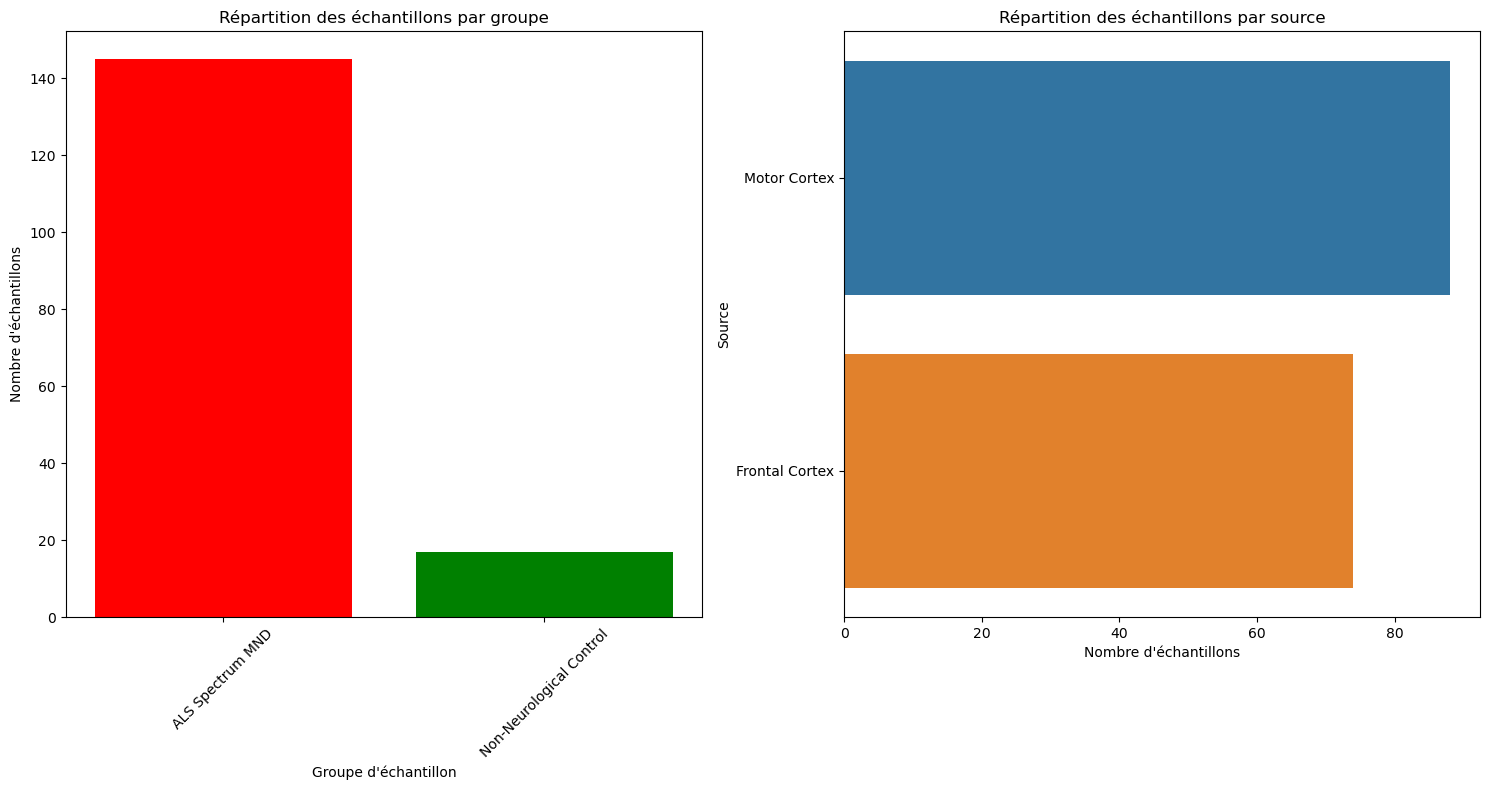

In [7]:
# Préparation des données pour les visualisations
sample_group_counts = df_final['Sample group'].value_counts()
source_counts = df_final['Source'].value_counts()

# Création des visualisations
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

colors = ['red', 'green']  
bars = ax[0].bar(sample_group_counts.index, sample_group_counts.values, color=colors) 
ax[0].set_title('Répartition des échantillons par groupe')
ax[0].set_xlabel('Groupe d\'échantillon')
ax[0].set_ylabel('Nombre d\'échantillons')
ax[0].tick_params(axis='x', rotation=45)

# Répartition des échantillons par source
sns.barplot(x=source_counts.values, y=source_counts.index, ax=ax[1], orient='h')
ax[1].set_title('Répartition des échantillons par source')
ax[1].set_xlabel('Nombre d\'échantillons')
ax[1].set_ylabel('Source')

plt.tight_layout()
plt.show()


**Interprétation :**

Les deux graphiques illustrent la répartition des échantillons de données RNA-Seq. Le premier graphique en barres rouges et vertes montre la répartition des échantillons par groupe, avec une prédominance marquée du groupe "ALS Spectrum MND" (145 échantillons) par rapport au "Non-Neurological Control" (17 échantillons). Le second graphique, en bleu et orange, indique la répartition des échantillons par source, distinguant ceux provenant du "Motor Cortex" (88 échantillons) et du "Frontal Cortex" (74 échantillons), avec un nombre plus élevé d'échantillons issus du "Motor Cortex". 

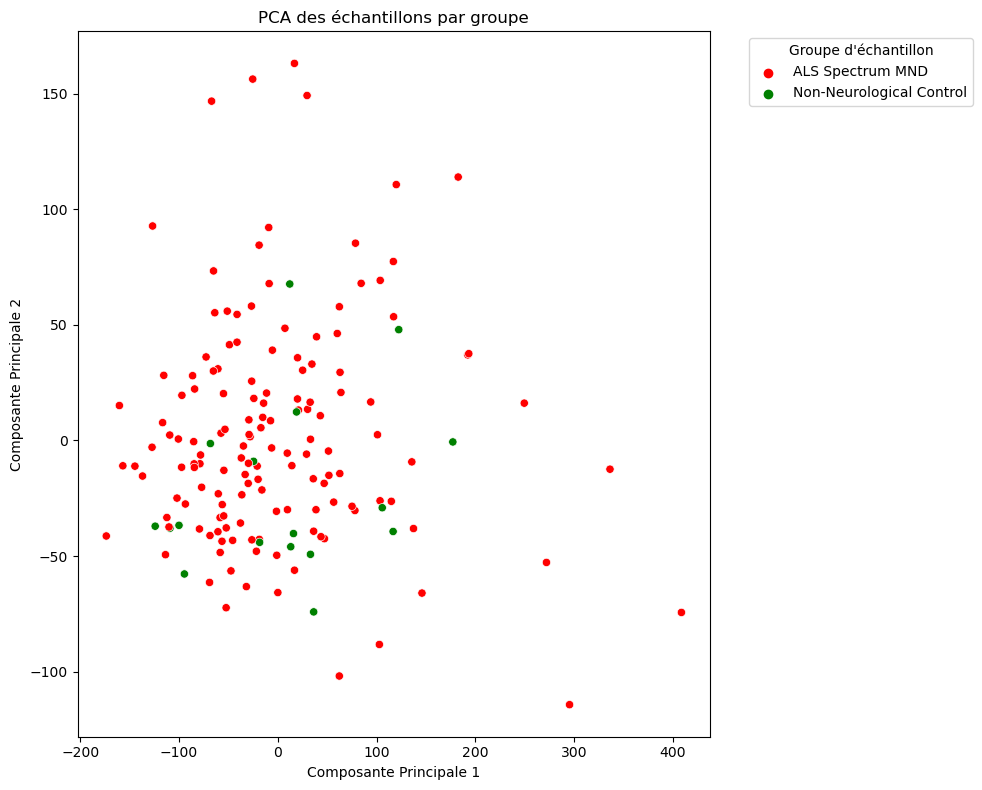

In [8]:
# Sélection des données numériques pour la PCA et normalisation
df_numeric = df_final.drop(columns=['Sample group', 'Subject id', 'Source'])
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_numeric)

pca = PCA(n_components=2)  # Réduction à 2 composantes principales pour la visualisation
principal_components = pca.fit_transform(df_normalized)
principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
principal_df['Sample group'] = df_final['Sample group']

# Define custom palette
custom_palette = {'ALS Spectrum MND': 'red', 'Non-Neurological Control': 'green'}

# Visualisation de la PCA avec palette personnalisée
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Sample group', data=principal_df, palette=custom_palette)
plt.title('PCA des échantillons par groupe')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend(title='Groupe d\'échantillon', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

**Interprétation :**

Le graphique montre une analyse en composantes principales (PCA) qui a réduit les données RNA-Seq à deux dimensions principales. Les points rouges représentent les échantillons du spectre de la SLA (ALS Spectrum MND) tandis que les points verts représentent les témoins non neurologiques (Non-Neurological Control). Les deux groupes ne montrent pas une séparation claire, indiquant une variabilité complexe et peut-être des similitudes dans l'expression génique entre les patients SLA et les témoins. 

Les points verts et rouges se chevauchent, ce qui suggère que les caractéristiques des deux
groupes se superposent dans l'espace de représentation des deux premières composantes
principales. De plus, certains points rouges se chevauchent, ce qui peut indiquer une certaine
hétérogénéité des patients atteints de la maladie ALS. Enfin, il est important de noter que
certains points rouges sont isolés à l'extrême du graphe, ce qui peut indiquer une forte
variance dans les caractéristiques de ces patients par rapport au reste du groupe.

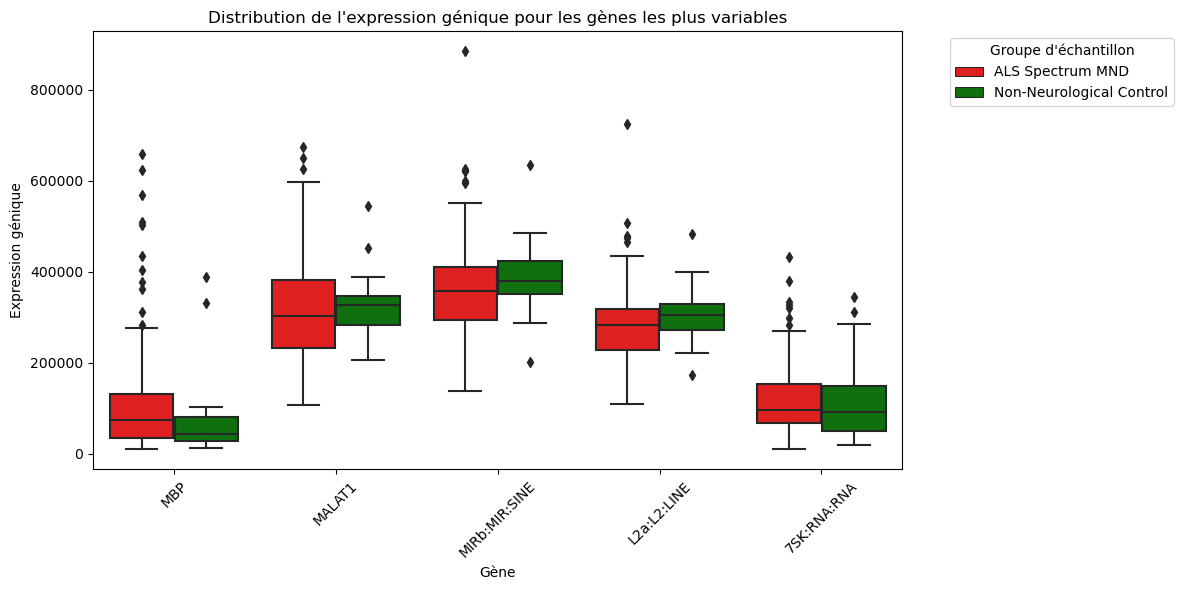

In [9]:
# Calcul de la variance pour chaque gène
gene_variances = df_numeric.var().sort_values(ascending=False)

# Sélection des 5 gènes ayant la plus grande variance pour simplifier la visualisation
top_genes = gene_variances.head(5).index.tolist()

# Préparation des données pour les boxplots
df_top_genes = df_final[['Sample group'] + top_genes].melt(id_vars=['Sample group'], var_name='Gene', value_name='Expression')

# Visualisation des boxplots pour les gènes sélectionnés, séparés par groupe d'échantillon avec palette personnalisée
plt.figure(figsize=(12, 6))
sns.boxplot(x='Gene', y='Expression', hue='Sample group', data=df_top_genes, palette=custom_palette)
plt.title('Distribution de l\'expression génique pour les gènes les plus variables')
plt.xlabel('Gène')
plt.ylabel('Expression génique')
plt.xticks(rotation=45)
plt.legend(title='Groupe d\'échantillon', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Interprétation :**

On a choisi de réaliser cette visualisation pour mettre en évidence les variations d'expression génique entre les patients atteints de SLA et les témoins sains. Les gènes ont été sélectionnés sur la base de leur grande variabilité d'expression, ce qui peut indiquer une implication potentielle dans la maladie. La boîte à moustaches illustre la distribution des niveaux d'expression pour chaque gène, où la boîte elle-même représente l'étendue interquartile et la ligne médiane. Les diamants représentent les outliers, indiquant les valeurs qui s'écartent significativement de la distribution typique. Analysons ceci plus en profondeur:

- **MBP :** Le MBP montre une médiane d'expression plus élevée chez les patients atteints de SLA par rapport au groupe témoin, avec des outliers indiquant une grande variabilité de l'expression chez certains patients.


- **MALAT1 :** MALAT1 présente une gamme d'expression assez large dans les deux groupes, avec une médiane légèrement plus haute chez les patients SLA, ce qui suggère une variabilité dans l'expression de ce gène.


- **MIRb:MIR:SINE :** L'expression de MIRb:MIR:SINE est plus cohérente dans le groupe témoin mais montre une plus grande variabilité dans le groupe SLA, indiquée par la longueur de la boîte et le nombre d'outliers.


- **L2a:L2:LINE :** La boîte à moustaches pour L2a:L2:LINE révèle une expression médiane similaire entre les groupes, mais avec une gamme interquartile plus large dans le groupe SLA, ce qui pourrait indiquer des perturbations régulatrices associées à la maladie.


- **7SK:RNA:RNA :** Pour 7SK:RNA:RNA, la médiane d'expression est similaire entre les groupes, mais le groupe SLA présente une plus grande dispersion des données, y compris plusieurs outliers à haute expression.

D'après les résultats, on peut voir que certains gènes, comme MBP, montrent une médiane d'expression plus élevée dans le groupe SLA, suggérant une dysrégulation potentielle dans la maladie, tandis que d'autres gènes présentent une grande dispersion indiquant une hétérogénéité de la réponse des patients à la SLA.

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


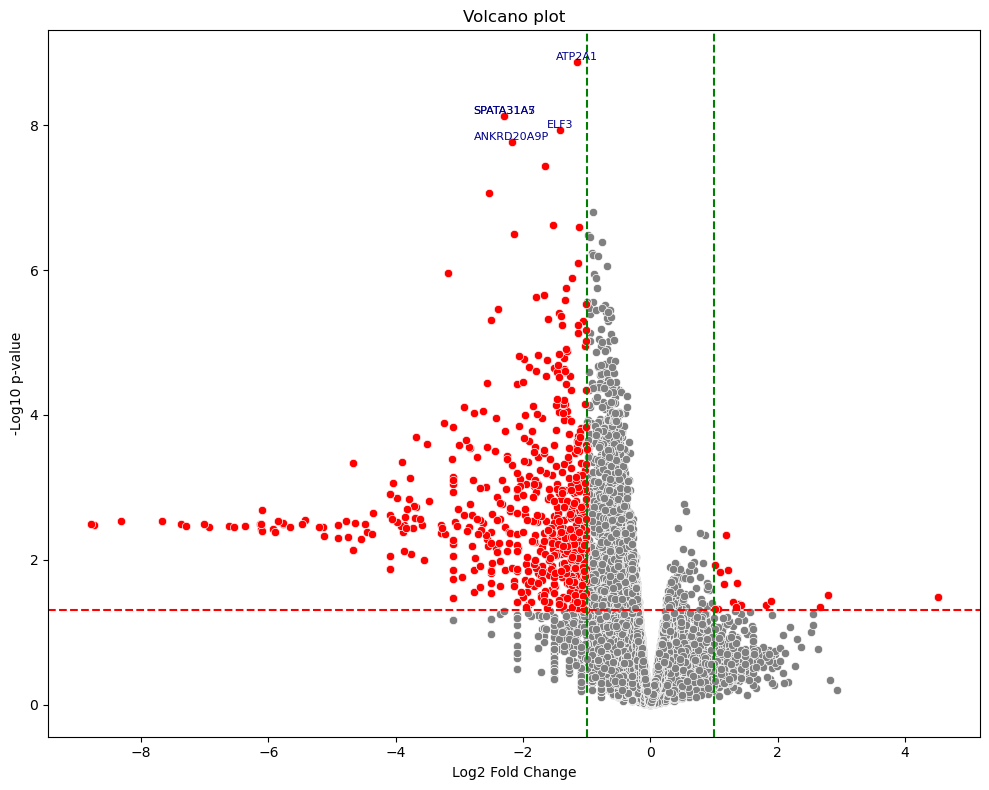

,gene,log2_fold_change,-log10_p_value
28,ATP2A1,-1.151630,8.868860
673,SPATA31A5,-2.295980,8.124373
674,SPATA31A7,-2.295980,8.124373
154,ELF3,-1.417452,7.935460
17,ANKRD20A9P,-2.174565,7.763465


In [10]:
# Définition des groupes ALS et témoins
df_als = df_final[df_final['Sample group'] == 'ALS Spectrum MND']
df_control = df_final[df_final['Sample group'] == 'Non-Neurological Control']

# Sélection des colonnes d'expression génique uniquement (exclusion des trois dernières colonnes)
gene_columns = df_final.columns[:-3]

# Calcul de l'expression moyenne pour chaque gène dans chaque groupe
mean_als = df_als[gene_columns].mean()
mean_control = df_control[gene_columns].mean()

# Calcul du changement de pli log2 et des valeurs p pour chaque gène
log2_fold_changes = np.log2(mean_als / mean_control)
p_values = [ttest_ind(df_als[gene].dropna(), df_control[gene].dropna()).pvalue for gene in gene_columns]

# Création d'un DataFrame avec les résultats
results_df = pd.DataFrame({
    'gene': gene_columns,
    'log2_fold_change': log2_fold_changes,
    '-log10_p_value': -np.log10(p_values)
})

# Définition des seuils de signification
p_value_threshold = 0.05
fold_change_threshold = 1  # Ajuster ce seuil si nécessaire

# Filtrage pour les gènes significatifs
significant_genes = results_df[(results_df['-log10_p_value'] > -np.log10(p_value_threshold)) &
                               (abs(results_df['log2_fold_change']) > fold_change_threshold)]

# Création du graphique en volcan
plt.figure(figsize=(10, 8))
sns.scatterplot(x='log2_fold_change', y='-log10_p_value', data=results_df, color='grey')
sns.scatterplot(x='log2_fold_change', y='-log10_p_value', data=significant_genes, color='red')
plt.title('Volcano plot')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 p-value')

# Ajout des lignes de seuil
plt.axhline(y=-np.log10(p_value_threshold), color='red', linestyle='--')
plt.axvline(x=fold_change_threshold, color='green', linestyle='--')
plt.axvline(x=-fold_change_threshold, color='green', linestyle='--')

# Annotation des 5 gènes significatifs les plus élevés
top_genes_to_annotate = significant_genes.nlargest(5, '-log10_p_value')
for index, row in top_genes_to_annotate.iterrows():
    plt.text(row['log2_fold_change'], row['-log10_p_value'], row['gene'],
             color='darkblue', fontsize=8, ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Réinitialisation de l'index du DataFrame significant_genes si les noms de gènes sont définis comme index
significant_genes.reset_index(drop=True, inplace=True)

# Création d'un tableau des gènes significatifs sans colonnes de noms de gènes en double
significant_genes_table = significant_genes.nlargest(5, '-log10_p_value')[['gene', 'log2_fold_change', '-log10_p_value']]
significant_genes_table

**Interprétation :**

Dans cette étape, nous avons appliqué un t-test pour comparer les moyennes d'expression d'un
gène entre deux groupes (par exemple, les sujets témoins versus les personnes atteintes de
ALS). Nous avons effectué un t-test pour chaque gène.
Pour visualiser les résultats de manière claire et informative, nous avons utilisé un volcano
plot. Ce graphique permet d'identifier rapidement les gènes présentant des différences
d'expression statistiquement significatives et des changements d'expression biologiquement
pertinents entre les groupes malades et non malades.

L'axe des abscisses (Log2 Fold Change) montre la différence d'expression entre deux conditions. Un Log2 Fold Change positif indique une sur-expression, tandis qu'une valeur négative indique une sous-expression.
L'axe des ordonnées (-Log10 p-value) indique la signification statistique. Plus une valeur est haute, plus le résultat est considéré comme statistiquement significatif sachant que p = 0,05.

Les lignes verticales vertes représentent le seuil de changement d'expression considéré comme significatif, tandis que la ligne horizontale rouge représente le seuil de signification statistique. Les points au-dessus de cette ligne sont les gènes dont l'expression est significativement différente.

Les points rouges situés à l'extérieur des lignes verticales et au-dessus de la ligne horizontale représentent les gènes significatifs. Les gènes étiquetés sur le graphique sont ceux qui présentent les changements d'expression les plus importants et les plus significatifs, ce qui en fait des candidats d'intérêt.


# Conclusion :

Au terme de ce projet, nous avons mis en oeuvre un processus ETL pour préparer et analyser un ensemble de données RNA-Seq dans le contexte de la sclérose latérale amyotrophique (SLA). Les visualisations de données telles que les PCA et les volcano plots ont permis de distinguer les gènes avec une expression différentielle significative entre les patients SLA et patients sains. Ces analyses nous ont offert des aperçus sur les gènes qui pourraient potentiellement jouer un rôle dans la SLA, ouvrant des pistes pour de futures recherches et potentiellement pour le développement de stratégies thérapeutiques. Ce projet illustre l'importance d'une préparation minutieuse des données pour une interprétation correcte et significative.
